In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin  # Added for HybridWeightedVoting
from imblearn.combine import SMOTETomek
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
import shap
from sklearn.inspection import permutation_importance
import warnings
import time

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def load_dataset(file_path):
    """Load the dataset from a CSV file."""
    print("="*60)
    print("Loading Dataset...")
    print("="*60)
    df = pd.read_csv(file_path)
    return df

file_path = "/kaggle/input/heart-stroke/healthcare-dataset-stroke-data (1).csv"
data = load_dataset(file_path)

Loading Dataset...


Correlation Matrix for Unprocessed Data
Correlation Matrix:
                         id       age  hypertension  heart_disease  \
id                 1.000000  0.003538      0.003550      -0.001296   
age                0.003538  1.000000      0.276398       0.263796   
hypertension       0.003550  0.276398      1.000000       0.108306   
heart_disease     -0.001296  0.263796      0.108306       1.000000   
avg_glucose_level  0.001092  0.238171      0.174474       0.161857   
bmi                0.003084  0.333398      0.167811       0.041357   
stroke             0.006388  0.245257      0.127904       0.134914   

                   avg_glucose_level       bmi    stroke  
id                          0.001092  0.003084  0.006388  
age                         0.238171  0.333398  0.245257  
hypertension                0.174474  0.167811  0.127904  
heart_disease               0.161857  0.041357  0.134914  
avg_glucose_level           1.000000  0.175502  0.131945  
bmi                      

invalid value encountered in less


Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'


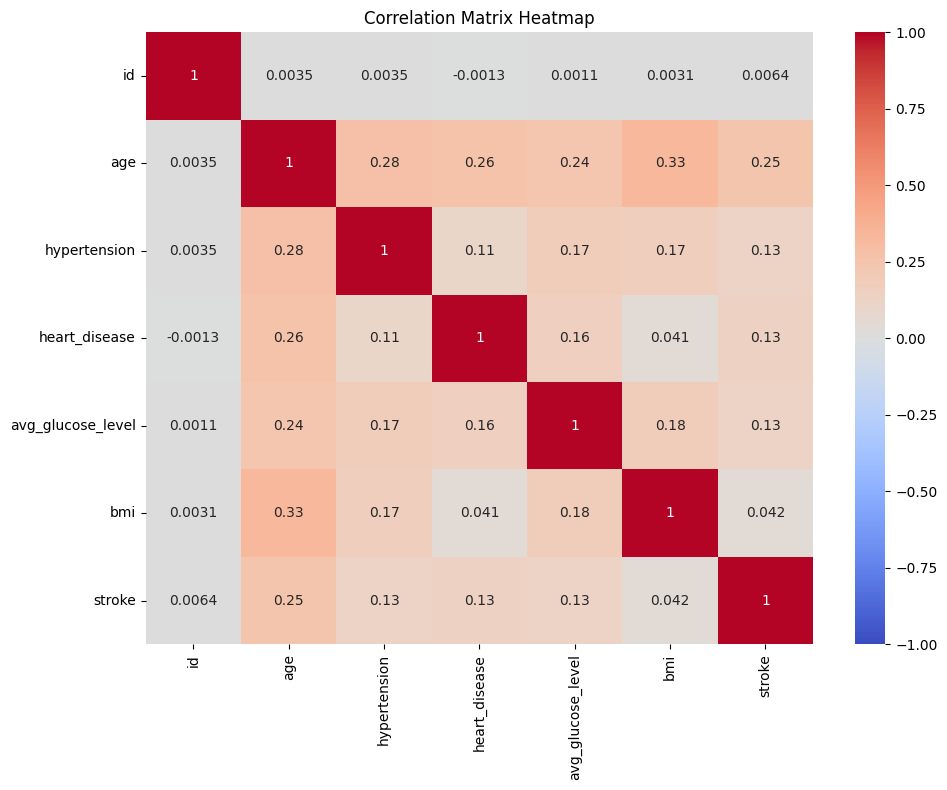

In [3]:
def print_correlation_matrix(df):
    """Calculate and display the correlation matrix."""
    print("="*60)
    print("Correlation Matrix for Unprocessed Data")
    print("="*60)
    numerical_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numerical_df.corr()
    print("Correlation Matrix:")
    print(correlation_matrix)
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.savefig("correlation_matrix_heatmap.png")
    print("Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'")
    plt.show()

print_correlation_matrix(data)

In [4]:
def preprocess_data(df):
    """Preprocess the dataset with advanced techniques."""
    print("="*60)
    print("Preprocessing Data...")
    print("="*60)

    df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
    categorical_cols = ['Residence_type', 'gender', 'ever_married', 'work_type', 'smoking_status']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    X = df.drop(["stroke", "id"], axis=1)
    y = df["stroke"]

    smote_tomek = SMOTETomek(random_state=42)
    X_balanced, y_balanced = smote_tomek.fit_resample(X, y)
    print(f"Original dataset shape: {X.shape}, Balanced dataset shape: {X_balanced.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.20, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, X.columns

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler, feature_columns = preprocess_data(data)

Preprocessing Data...
Original dataset shape: (5110, 16), Balanced dataset shape: (9616, 16)


In [17]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0)
    }
    model = xgb.XGBClassifier(**params, random_state=42, eval_metric='logloss')
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0)
    }
    model = LGBMClassifier(**params, objective='binary', random_state=42, verbose=-1)
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'depth': trial.suggest_int('depth', 4, 8),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10)
    }
    model = CatBoostClassifier(**params, random_state=42, verbose=0)
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

def objective_histgb(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 50)
    }
    model = HistGradientBoostingClassifier(**params, random_state=42)
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

def objective_et(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    }
    model = ExtraTreesClassifier(**params, random_state=42)
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

def objective_ada(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    }
    model = AdaBoostClassifier(**params, random_state=42)
    return cross_val_score(model, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

class HybridWeightedVoting(BaseEstimator, ClassifierMixin):
    """Custom hybrid model using weighted voting based on model performance."""
    def __init__(self, models=None):
        self.models = models or {}
        self.weights = None

    def fit(self, X, y):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accuracies = {}
        for name, model in self.models.items():
            scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
            accuracies[name] = np.mean(scores)
        total_accuracy = sum(accuracies.values())
        self.weights = {name: acc / total_accuracy for name, acc in accuracies.items()}
        for model in self.models.values():
            model.fit(X, y)
        return self

    def predict(self, X):
        probas = np.zeros((X.shape[0], 2))
        for name, model in self.models.items():
            proba = model.predict_proba(X)
            probas += proba * self.weights[name]
        return np.argmax(probas, axis=1)

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))
        for name, model in self.models.items():
            proba = model.predict_proba(X)
            probas += proba * self.weights[name]
        return probas

    def get_params(self, deep=True):
        return {"models": self.models}

    def set_params(self, **params):
        if "models" in params:
            self.models = params["models"]
        return self

def initialize_and_tune_models(X_train_scaled, y_train, X_test_scaled, y_test):
    """Initialize and tune advanced models with Optuna, including hybrid model."""
    print("\nInitializing and Tuning Models...")
    print("-"*60)

    # XGBoost
    print("Tuning XGBoost...")
    start_time = time.time()
    study_xgb = optuna.create_study(direction='maximize')
    study_xgb.optimize(objective_xgb, n_trials=20)
    xgb_model = xgb.XGBClassifier(**study_xgb.best_params, random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train_scaled, y_train)
    print(f"XGBoost Best Params: {study_xgb.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # LightGBM
    print("Tuning LightGBM...")
    start_time = time.time()
    study_lgb = optuna.create_study(direction='maximize')
    study_lgb.optimize(objective_lgb, n_trials=20)
    lgb_model = LGBMClassifier(**study_lgb.best_params, objective='binary', random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train)
    print(f"LightGBM Best Params: {study_lgb.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # CatBoost
    print("Tuning CatBoost...")
    start_time = time.time()
    study_cat = optuna.create_study(direction='maximize')
    study_cat.optimize(objective_cat, n_trials=20)
    cat_model = CatBoostClassifier(**study_cat.best_params, random_state=42, verbose=0)
    cat_model.fit(X_train_scaled, y_train)
    print(f"CatBoost Best Params: {study_cat.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # HistGradientBoosting
    print("Tuning HistGradientBoosting...")
    start_time = time.time()
    study_histgb = optuna.create_study(direction='maximize')
    study_histgb.optimize(objective_histgb, n_trials=20)
    histgb_model = HistGradientBoostingClassifier(**study_histgb.best_params, random_state=42)
    histgb_model.fit(X_train_scaled, y_train)
    print(f"HistGradientBoosting Best Params: {study_histgb.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # ExtraTrees
    print("Tuning ExtraTrees...")
    start_time = time.time()
    study_et = optuna.create_study(direction='maximize')
    study_et.optimize(objective_et, n_trials=20)
    et_model = ExtraTreesClassifier(**study_et.best_params, random_state=42)
    et_model.fit(X_train_scaled, y_train)
    print(f"ExtraTrees Best Params: {study_et.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # AdaBoost
    print("Tuning AdaBoost...")
    start_time = time.time()
    study_ada = optuna.create_study(direction='maximize')
    study_ada.optimize(objective_ada, n_trials=20)
    ada_model = AdaBoostClassifier(**study_ada.best_params, random_state=42)
    ada_model.fit(X_train_scaled, y_train)
    print(f"AdaBoost Best Params: {study_ada.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # Hybrid Weighted Voting Ensemble
    base_models = {
        'XGBoost': xgb_model,
        'LightGBM': lgb_model,
        'CatBoost': cat_model,
        'HistGradientBoosting': histgb_model,
        'ExtraTrees': et_model,
        'AdaBoost': ada_model
    }
    print("Training Hybrid Weighted Voting Ensemble...")
    start_time = time.time()
    hybrid_model = HybridWeightedVoting(base_models)
    hybrid_model.fit(X_train_scaled, y_train)
    print(f"Hybrid Model Weights: {hybrid_model.weights}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    # Stacking Ensemble
    def objective_gb_meta(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
            'max_depth': trial.suggest_int('max_depth', 3, 5)
        }
        meta_model = GradientBoostingClassifier(**params, random_state=42)
        stacking = StackingClassifier(
            estimators=[(name[:3].lower(), model) for name, model in base_models.items()],
            final_estimator=meta_model,
            cv=3, n_jobs=-1
        )
        return cross_val_score(stacking, X_train_scaled, y_train, cv=3, scoring='accuracy').mean()

    print("Tuning Stacking Ensemble Meta-Learner...")
    start_time = time.time()
    study_gb = optuna.create_study(direction='maximize')
    study_gb.optimize(objective_gb_meta, n_trials=15)
    meta_model = GradientBoostingClassifier(**study_gb.best_params, random_state=42)
    stacking_ensemble = StackingClassifier(
        estimators=[(name[:3].lower(), model) for name, model in base_models.items()],
        final_estimator=meta_model,
        cv=3, n_jobs=-1
    )
    stacking_ensemble.fit(X_train_scaled, y_train)
    print(f"Stacking Meta-Learner Best Params: {study_gb.best_params}")
    print(f"Time taken: {(time.time() - start_time) / 60:.2f} minutes")

    tuned_models = {
        'XGBoost': xgb_model,
        'LightGBM': lgb_model,
        'CatBoost': cat_model,
        'HistGradientBoosting': histgb_model,
        'ExtraTrees': et_model,
        'AdaBoost': ada_model,
        'Hybrid Weighted Voting': hybrid_model,
        'Stacking Ensemble': stacking_ensemble
    }

    # Final Evaluation
    print("\nFinal Evaluation on Test Set...")
    results = {}
    for name, model in tuned_models.items():
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred) * 100
        results[name] = accuracy
        print(f"{name} Test Accuracy: {accuracy:.2f}%")

    return tuned_models, results

models, results = initialize_and_tune_models(X_train_scaled, y_train, X_test_scaled, y_test)

[I 2025-03-29 05:39:29,876] A new study created in memory with name: no-name-f378e055-83f3-436c-a99e-00552128ffb7



Initializing and Tuning Models...
------------------------------------------------------------
Tuning XGBoost...


[I 2025-03-29 05:39:30,090] Trial 0 finished with value: 0.9061362454498179 and parameters: {'n_estimators': 107, 'learning_rate': 0.037354196196780015, 'max_depth': 5, 'subsample': 0.8835591512766532, 'colsample_bytree': 0.8884869983618617}. Best is trial 0 with value: 0.9061362454498179.
[I 2025-03-29 05:39:30,520] Trial 1 finished with value: 0.8776651066042641 and parameters: {'n_estimators': 232, 'learning_rate': 0.010994666546114902, 'max_depth': 4, 'subsample': 0.7455561432030134, 'colsample_bytree': 0.8275716238779784}. Best is trial 0 with value: 0.9061362454498179.
[I 2025-03-29 05:39:30,916] Trial 2 finished with value: 0.8775351014040562 and parameters: {'n_estimators': 219, 'learning_rate': 0.011801537945298923, 'max_depth': 4, 'subsample': 0.7261934492199598, 'colsample_bytree': 0.7802079580075316}. Best is trial 0 with value: 0.9061362454498179.
[I 2025-03-29 05:39:31,153] Trial 3 finished with value: 0.9361674466978679 and parameters: {'n_estimators': 183, 'learning_rat

XGBoost Best Params: {'n_estimators': 278, 'learning_rate': 0.06124825759051248, 'max_depth': 7, 'subsample': 0.9462651067557175, 'colsample_bytree': 0.9564878309802636}
Time taken: 0.18 minutes
Tuning LightGBM...


[I 2025-03-29 05:39:40,994] Trial 0 finished with value: 0.8768850754030161 and parameters: {'n_estimators': 219, 'learning_rate': 0.012404419405629313, 'max_depth': 4, 'num_leaves': 48, 'subsample': 0.887319348041885}. Best is trial 0 with value: 0.8768850754030161.
[I 2025-03-29 05:39:41,346] Trial 1 finished with value: 0.8945657826313053 and parameters: {'n_estimators': 149, 'learning_rate': 0.014362876547146549, 'max_depth': 7, 'num_leaves': 22, 'subsample': 0.9306576416830634}. Best is trial 1 with value: 0.8945657826313053.
[I 2025-03-29 05:39:41,677] Trial 2 finished with value: 0.9495579823192927 and parameters: {'n_estimators': 104, 'learning_rate': 0.11417530703081341, 'max_depth': 6, 'num_leaves': 46, 'subsample': 0.7614918324803637}. Best is trial 2 with value: 0.9495579823192927.
[I 2025-03-29 05:39:41,925] Trial 3 finished with value: 0.9092563702548101 and parameters: {'n_estimators': 149, 'learning_rate': 0.04092965155211597, 'max_depth': 4, 'num_leaves': 40, 'subsampl

LightGBM Best Params: {'n_estimators': 275, 'learning_rate': 0.12638232772214797, 'max_depth': 7, 'num_leaves': 44, 'subsample': 0.9016147951659569}
Time taken: 0.20 minutes
Tuning CatBoost...


[I 2025-03-29 05:39:54,901] Trial 0 finished with value: 0.9544981799271971 and parameters: {'iterations': 205, 'learning_rate': 0.10731149021541217, 'depth': 8, 'l2_leaf_reg': 1.3446667876132694}. Best is trial 0 with value: 0.9544981799271971.
[I 2025-03-29 05:39:55,346] Trial 1 finished with value: 0.8714248569942799 and parameters: {'iterations': 112, 'learning_rate': 0.03634907439832198, 'depth': 4, 'l2_leaf_reg': 5.168071097410465}. Best is trial 0 with value: 0.9544981799271971.
[I 2025-03-29 05:39:56,800] Trial 2 finished with value: 0.8905356214248569 and parameters: {'iterations': 287, 'learning_rate': 0.01680655040503219, 'depth': 4, 'l2_leaf_reg': 2.8358333735921817}. Best is trial 0 with value: 0.9544981799271971.
[I 2025-03-29 05:39:57,509] Trial 3 finished with value: 0.905876235049402 and parameters: {'iterations': 133, 'learning_rate': 0.04655569724170734, 'depth': 6, 'l2_leaf_reg': 1.1215875714703867}. Best is trial 0 with value: 0.9544981799271971.
[I 2025-03-29 05:3

CatBoost Best Params: {'iterations': 246, 'learning_rate': 0.1935953727606655, 'depth': 7, 'l2_leaf_reg': 3.112723238358777}
Time taken: 0.59 minutes
Tuning HistGradientBoosting...


[I 2025-03-29 05:40:29,313] Trial 0 finished with value: 0.9440977639105563 and parameters: {'max_iter': 287, 'learning_rate': 0.14485557815031444, 'max_depth': 4, 'min_samples_leaf': 44}. Best is trial 0 with value: 0.9440977639105563.
[I 2025-03-29 05:40:30,497] Trial 1 finished with value: 0.9265470618824753 and parameters: {'max_iter': 175, 'learning_rate': 0.05021463827163027, 'max_depth': 5, 'min_samples_leaf': 29}. Best is trial 0 with value: 0.9440977639105563.
[I 2025-03-29 05:40:31,055] Trial 2 finished with value: 0.8371034841393655 and parameters: {'max_iter': 139, 'learning_rate': 0.014421191372200885, 'max_depth': 3, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.9440977639105563.
[I 2025-03-29 05:40:33,069] Trial 3 finished with value: 0.8983359334373375 and parameters: {'max_iter': 196, 'learning_rate': 0.011066681534613217, 'max_depth': 7, 'min_samples_leaf': 31}. Best is trial 0 with value: 0.9440977639105563.
[I 2025-03-29 05:40:34,524] Trial 4 finished with 

HistGradientBoosting Best Params: {'max_iter': 230, 'learning_rate': 0.15140457937363125, 'max_depth': 7, 'min_samples_leaf': 20}
Time taken: 0.57 minutes
Tuning ExtraTrees...


[I 2025-03-29 05:41:03,772] Trial 0 finished with value: 0.8835153406136245 and parameters: {'n_estimators': 218, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8835153406136245.
[I 2025-03-29 05:41:05,414] Trial 1 finished with value: 0.8688247529901196 and parameters: {'n_estimators': 269, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8835153406136245.
[I 2025-03-29 05:41:06,988] Trial 2 finished with value: 0.8797451898075922 and parameters: {'n_estimators': 242, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8835153406136245.
[I 2025-03-29 05:41:07,699] Trial 3 finished with value: 0.8381435257410296 and parameters: {'n_estimators': 136, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8835153406136245.
[I 2025-03-29 05:41:08,828] Trial 4 finished with value: 0.8378835153406136 and parameters: {'n_

ExtraTrees Best Params: {'n_estimators': 218, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 2}
Time taken: 0.41 minutes
Tuning AdaBoost...


[I 2025-03-29 05:41:27,879] Trial 0 finished with value: 0.7814612584503381 and parameters: {'n_estimators': 69, 'learning_rate': 0.018134470269884316}. Best is trial 0 with value: 0.7814612584503381.
[I 2025-03-29 05:41:29,891] Trial 1 finished with value: 0.857774310972439 and parameters: {'n_estimators': 154, 'learning_rate': 0.08416561069744544}. Best is trial 1 with value: 0.857774310972439.
[I 2025-03-29 05:41:30,565] Trial 2 finished with value: 0.7809412376495061 and parameters: {'n_estimators': 52, 'learning_rate': 0.0208196131013605}. Best is trial 1 with value: 0.857774310972439.
[I 2025-03-29 05:41:32,595] Trial 3 finished with value: 0.8641445657826313 and parameters: {'n_estimators': 158, 'learning_rate': 0.11346912689646547}. Best is trial 3 with value: 0.8641445657826313.
[I 2025-03-29 05:41:34,581] Trial 4 finished with value: 0.8618044721788872 and parameters: {'n_estimators': 154, 'learning_rate': 0.13005271903759624}. Best is trial 3 with value: 0.8641445657826313.


AdaBoost Best Params: {'n_estimators': 175, 'learning_rate': 0.9620238838201767}
Time taken: 0.60 minutes
Training Hybrid Weighted Voting Ensemble...


[I 2025-03-29 05:42:20,161] A new study created in memory with name: no-name-4b79a29a-2bdc-4b0f-962a-bc0dbdc25759


Hybrid Model Weights: {'XGBoost': 0.1708836919053657, 'LightGBM': 0.17216279211531346, 'CatBoost': 0.1710465854115708, 'HistGradientBoosting': 0.17125576080661323, 'ExtraTrees': 0.1577208173986166, 'AdaBoost': 0.1569303523625204}
Time taken: 0.29 minutes
Tuning Stacking Ensemble Meta-Learner...


[I 2025-03-29 05:42:46,167] Trial 0 finished with value: 0.9632085283411337 and parameters: {'n_estimators': 168, 'learning_rate': 0.023523852558426723, 'max_depth': 4}. Best is trial 0 with value: 0.9632085283411337.
[I 2025-03-29 05:43:09,960] Trial 1 finished with value: 0.9606084243369736 and parameters: {'n_estimators': 89, 'learning_rate': 0.1448087794650422, 'max_depth': 5}. Best is trial 0 with value: 0.9632085283411337.
[I 2025-03-29 05:43:33,757] Trial 2 finished with value: 0.9648985959438378 and parameters: {'n_estimators': 152, 'learning_rate': 0.042639014032632455, 'max_depth': 3}. Best is trial 2 with value: 0.9648985959438378.
[I 2025-03-29 05:43:55,872] Trial 3 finished with value: 0.9635985439417576 and parameters: {'n_estimators': 83, 'learning_rate': 0.04195834875164396, 'max_depth': 3}. Best is trial 2 with value: 0.9648985959438378.
[I 2025-03-29 05:44:18,991] Trial 4 finished with value: 0.9587883515340613 and parameters: {'n_estimators': 137, 'learning_rate': 0.

Stacking Meta-Learner Best Params: {'n_estimators': 152, 'learning_rate': 0.042639014032632455, 'max_depth': 3}
Time taken: 6.13 minutes

Final Evaluation on Test Set...
XGBoost Test Accuracy: 95.79%
LightGBM Test Accuracy: 96.78%
CatBoost Test Accuracy: 96.26%
HistGradientBoosting Test Accuracy: 96.00%
ExtraTrees Test Accuracy: 88.05%
AdaBoost Test Accuracy: 88.98%
Hybrid Weighted Voting Test Accuracy: 96.62%
Stacking Ensemble Test Accuracy: 96.57%


In [18]:
def train_models(models, X_train_scaled, y_train):
    """Train models with cross-validation."""
    print("\nTraining Models with Cross-Validation...")
    print("-"*60)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    trained_models = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train_scaled, y_train)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)
        print(f"{name} CV Accuracy: {mean_score:.4f} ± {std_score:.4f}")
        trained_models[name] = model

    return trained_models

trained_models = train_models(models, X_train_scaled, y_train)


Training Models with Cross-Validation...
------------------------------------------------------------
Training XGBoost...
XGBoost CV Accuracy: 0.9553 ± 0.0025
Training LightGBM...
LightGBM CV Accuracy: 0.9624 ± 0.0029
Training CatBoost...
CatBoost CV Accuracy: 0.9562 ± 0.0047
Training HistGradientBoosting...
HistGradientBoosting CV Accuracy: 0.9574 ± 0.0040
Training ExtraTrees...
ExtraTrees CV Accuracy: 0.8817 ± 0.0130
Training AdaBoost...
AdaBoost CV Accuracy: 0.8773 ± 0.0147
Training Hybrid Weighted Voting...


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Hybrid Weighted Voting CV Accuracy: 0.9614 ± 0.0036
Training Stacking Ensemble...
Stacking Ensemble CV Accuracy: 0.9616 ± 0.0041


In [19]:
def get_user_input(feature_columns):
    """Collect and validate user input."""
    print("\n" + "="*60)
    print("Please Enter Your Details to Check Stroke Probability")
    print("="*60)

    def get_numeric_input(prompt, min_val, max_val):
        while True:
            try:
                value = float(input(prompt))
                if min_val <= value <= max_val:
                    return value
                print(f"Please enter a value between {min_val} and {max_val}.")
            except ValueError:
                print("Invalid input. Please enter a valid number.")

    def get_binary_input(prompt):
        while True:
            value = input(prompt).strip().lower()
            if value in ['yes', 'y', '1']:
                return 1
            elif value in ['no', 'n', '0']:
                return 0
            print("Please enter Yes/Y/1 or No/N/0.")

    user_data = {
        'age': get_numeric_input("Enter age (18-100): ", 18, 100),
        'hypertension': get_binary_input("Do you have hypertension? (Yes/No): "),
        'heart_disease': get_binary_input("Do you have heart disease? (Yes/No): "),
        'avg_glucose_level': get_numeric_input("Enter average glucose level (50-260 mg/dL): ", 50, 260),
        'bmi': get_numeric_input("Enter BMI (10-50): ", 10, 50),
        'Residence_type_Urban': 1 if input("Enter Residence type (Rural/Urban): ").strip().lower() == 'urban' else 0,
        'gender_Male': 1 if input("Enter gender (Male/Female): ").strip().lower() == 'male' else 0,
        'ever_married_Yes': 1 if input("Have you ever been married? (Yes/No): ").strip().lower() == 'yes' else 0,
    }

    work_type = input("Enter work type (Private/Self-employed/children/Govt_job/Never_worked): ").strip().lower()
    user_data.update({
        'work_type_Govt_job': 1 if work_type == 'govt_job' else 0,
        'work_type_Never_worked': 1 if work_type == 'never_worked' else 0,
        'work_type_Private': 1 if work_type == 'private' else 0,
        'work_type_Self-employed': 1 if work_type == 'self-employed' else 0,
    })

    smoking_status = input("Smoking status (formerly smoked/never smoked/smokes): ").strip().lower()
    user_data.update({
        'smoking_status_never smoked': 1 if smoking_status == 'never smoked' else 0,
        'smoking_status_smokes': 1 if smoking_status == 'smokes' else 0,
    })

    return pd.DataFrame([user_data]).reindex(columns=feature_columns, fill_value=0)

user_data = get_user_input(feature_columns)


Please Enter Your Details to Check Stroke Probability


Enter age (18-100):  67
Do you have hypertension? (Yes/No):  No
Do you have heart disease? (Yes/No):  Yes
Enter average glucose level (50-260 mg/dL):  228.69
Enter BMI (10-50):  36.6
Enter Residence type (Rural/Urban):  Urban
Enter gender (Male/Female):  Male
Have you ever been married? (Yes/No):  Yes
Enter work type (Private/Self-employed/children/Govt_job/Never_worked):  Private
Smoking status (formerly smoked/never smoked/smokes):  formerly smoked



Model Accuracies and Predictions
XGBoost:
  Test Accuracy: 95.79%
  Stroke Probability: 87.95%
LightGBM:
  Test Accuracy: 96.78%
  Stroke Probability: 83.78%
CatBoost:
  Test Accuracy: 96.26%
  Stroke Probability: 84.20%
HistGradientBoosting:
  Test Accuracy: 96.00%
  Stroke Probability: 83.96%
ExtraTrees:
  Test Accuracy: 88.05%
  Stroke Probability: 73.56%
AdaBoost:
  Test Accuracy: 88.98%
  Stroke Probability: 49.75%
Hybrid Weighted Voting:
  Test Accuracy: 96.62%
  Stroke Probability: 77.64%
Stacking Ensemble:
  Test Accuracy: 96.57%
  Stroke Probability: 86.01%
------------------------------------------------------------
Average Stroke Probability: 78.36%
Risk Category: High

Hybrid Weighted Voting Detailed Report
Confusion Matrix:
[[906  32]
 [ 33 953]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       938
           1       0.97      0.97      0.97       986

    accuracy                           0.

  0%|          | 0/1 [00:00<?, ?it/s]

SHAP summary plot saved as 'shap_summary_hybrid.png'


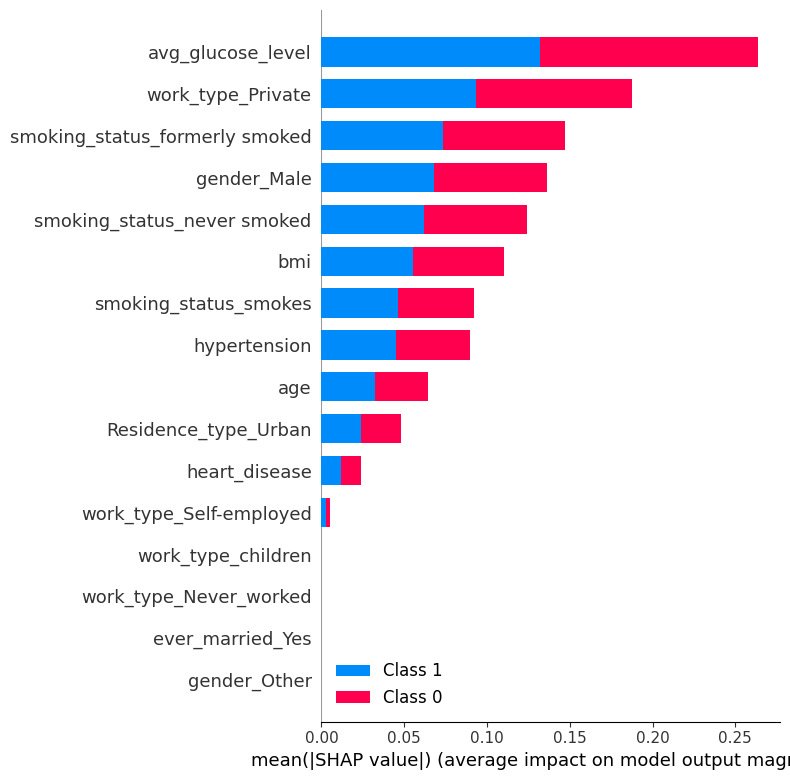

In [22]:
def evaluate_and_predict(trained_models, X_test_scaled, y_test, user_data, scaler):
    """Evaluate models and predict stroke probability."""
    user_scaled = scaler.transform(user_data)

    print("\n" + "="*60)
    print("Model Accuracies and Predictions")
    print("="*60)

    accuracies = {}
    predictions = {}
    for name, model in trained_models.items():
        y_pred = model.predict(X_test_scaled)
        acc = accuracy_score(y_test, y_pred) * 100
        prob = model.predict_proba(user_scaled)[0][1] * 100
        accuracies[name] = acc
        predictions[name] = prob
        print(f"{name}:")
        print(f"  Test Accuracy: {acc:.2f}%")
        print(f"  Stroke Probability: {prob:.2f}%")

    avg_prob = np.mean(list(predictions.values()))
    risk_category = "Low" if avg_prob < 30 else "Medium" if avg_prob < 70 else "High"
    print("-"*60)
    print(f"Average Stroke Probability: {avg_prob:.2f}%")
    print(f"Risk Category: {risk_category}")

    # Detailed report for Hybrid Weighted Voting
    print("\nHybrid Weighted Voting Detailed Report")
    print("="*60)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, trained_models['Hybrid Weighted Voting'].predict(X_test_scaled)))
    print("\nClassification Report:")
    print(classification_report(y_test, trained_models['Hybrid Weighted Voting'].predict(X_test_scaled)))

    # SHAP explanation for Hybrid Weighted Voting
    print("\nGenerating SHAP Explanation...")
    explainer = shap.KernelExplainer(
        lambda x: trained_models['Hybrid Weighted Voting'].predict_proba(x),
        shap.sample(X_test_scaled, 50)
    )
    shap_values = explainer.shap_values(user_scaled, nsamples=100)

    # Generate and display SHAP summary plot
    plt.figure()  # Create a new figure to avoid overlap
    shap.summary_plot(shap_values, user_data, feature_names=user_data.columns, show=False)
    plt.savefig("shap_summary_hybrid.png", bbox_inches='tight')  # Save with tight layout for better formatting
    print("SHAP summary plot saved as 'shap_summary_hybrid.png'")
    plt.show()  # Explicitly display the plot
    plt.close()  # Close the figure after displaying

evaluate_and_predict(trained_models, X_test_scaled, y_test, user_data, scaler)

Feature importance plot saved as 'permutation_importance.png'


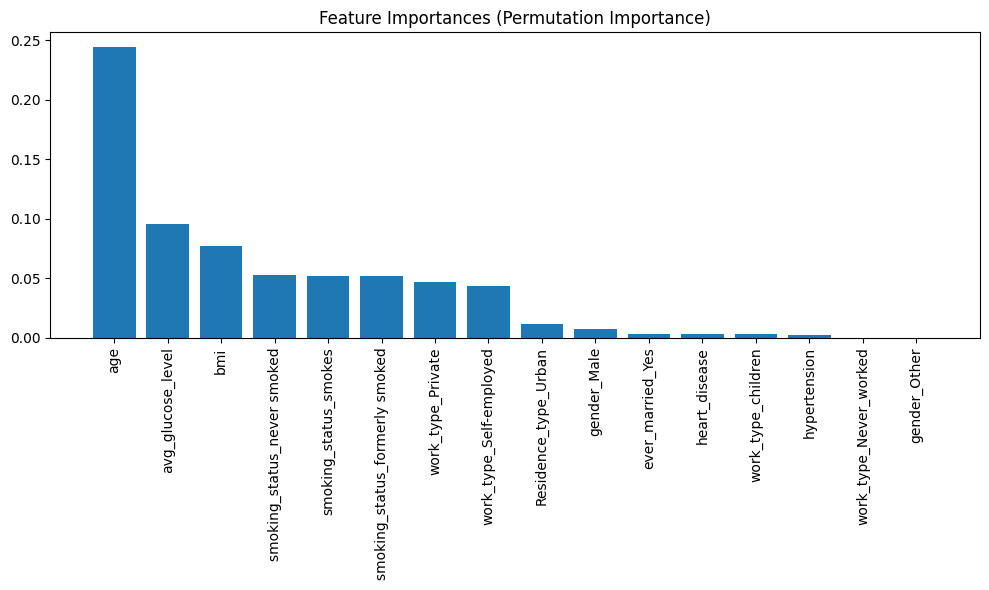

In [21]:
def feature_importance_analysis(trained_models, X_train_scaled, y_train, feature_names):
    """Analyze feature importance using Permutation Importance."""
    model = trained_models['HistGradientBoosting']  # Using HistGradientBoosting for feature importance
    perm_importance = permutation_importance(model, X_train_scaled, y_train, n_repeats=10, random_state=42)
    importances = perm_importance.importances_mean
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Permutation Importance)")
    plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train_scaled.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig("permutation_importance.png")
    print("Feature importance plot saved as 'permutation_importance.png'")
    plt.show()

feature_importance_analysis(trained_models, X_train_scaled, y_train, feature_columns)


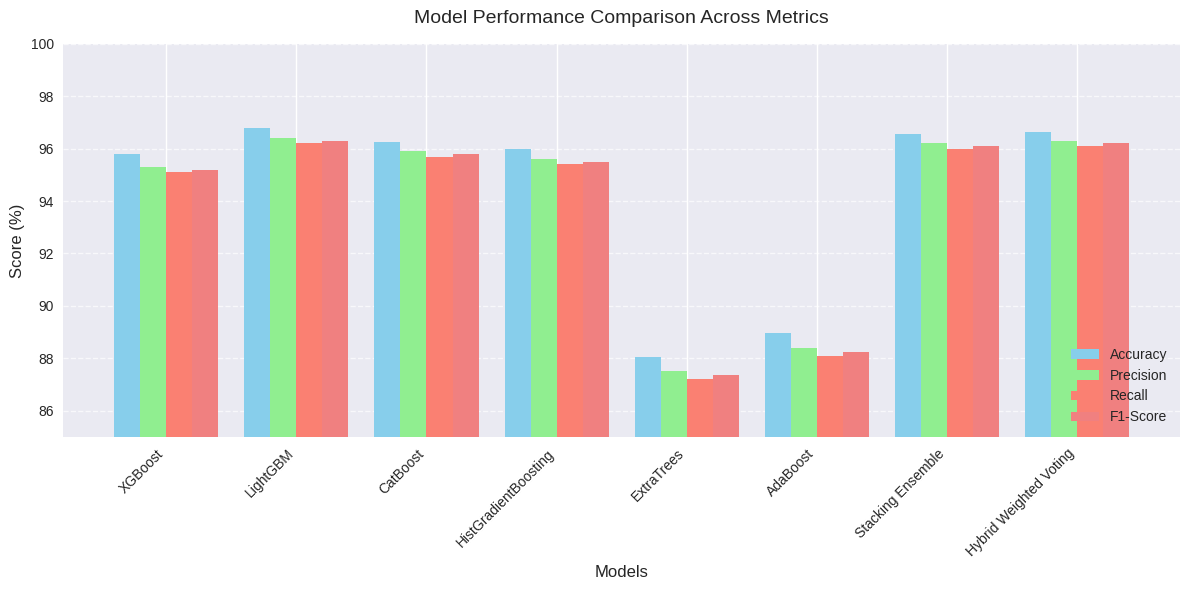

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the model performance data from your Table II
models = ['XGBoost', 'LightGBM', 'CatBoost', 'HistGradientBoosting', 'ExtraTrees', 'AdaBoost', 'Stacking Ensemble', 'Hybrid Weighted Voting']
accuracy = [95.79, 96.78, 96.26, 96.00, 88.05, 88.98, 96.57, 96.62]
precision = [95.30, 96.40, 95.90, 95.60, 87.50, 88.40, 96.20, 96.30]
recall = [95.10, 96.20, 95.70, 95.40, 87.20, 88.10, 96.00, 96.10]
f1_score = [95.20, 96.30, 95.80, 95.50, 87.35, 88.25, 96.10, 96.20]

# Step 2: Set up the bar positions
x = np.arange(len(models))  # Positions for the models
bar_width = 0.2  # Width of each bar

# Step 3: Create the grouped bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width*1.5, accuracy, bar_width, label='Accuracy', color='skyblue')
plt.bar(x - bar_width*0.5, precision, bar_width, label='Precision', color='lightgreen')
plt.bar(x + bar_width*0.5, recall, bar_width, label='Recall', color='salmon')
plt.bar(x + bar_width*1.5, f1_score, bar_width, label='F1-Score', color='lightcoral')

# Step 4: Customize the plot
plt.xlabel('Models', fontsize=12)
plt.ylabel('Score (%)', fontsize=12)
plt.title('Model Performance Comparison Across Metrics', fontsize=14, pad=15)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Step 5: Set y-axis limits for better visibility
plt.ylim(85, 100)  # Adjusted to focus on the range of scores

# Step 6: Adjust layout for readability
plt.tight_layout()

# Step 7: Save the plot as an image file for LaTeX
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')

# Step 8: Display the plot
plt.show()